In [0]:
from glob import glob
import os
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# import h5py
from keras.models import load_model
from keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img          # for image augmentation
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input                              # VGG pretarained model
import tensorflow as tf
from keras import backend as K

from sklearn.metrics import confusion_matrix                                              #metrics
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import f1_score, accuracy_score

Using TensorFlow backend.


> Data given in 3 folders with 2 class folders in each

In [0]:
data_dir  = '../input/chest-xray-pneumonia/chest_xray/chest_xray/'
train_dir = data_dir+'train/'
test_dir  = data_dir+'test/'
val_dir   = data_dir + 'val/'

> 2 classes - Normal and Pneumonia

In [0]:
normal_cases = glob(train_dir+'NORMAL/*.jpeg')
pneumonia_cases = glob(train_dir+'PNEUMONIA/*.jpeg')

In [0]:
print(len(normal_cases),len(pneumonia_cases))
print(len(normal_cases)/(len(normal_cases)+len(pneumonia_cases)),len(pneumonia_cases)/(len(normal_cases)+len(pneumonia_cases)))

1341 3875
0.2570935582822086 0.7429064417177914


> Unbalance data

In [0]:

train_data = []
trainset=[]

# adding all normal case images with label
for img in normal_cases:
    train_data.append((img,0))
   # n= cv2.imread(img)
    #trainset.append(n)

# adding all pneumonia case images with label
for img in pneumonia_cases:
    train_data.append((img, 1))

# converting list to datframe and shuffling 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)
train_data = train_data.sample(frac=1.).reset_index(drop=True)

In [0]:
#trainset = pd.DataFrame(trainset,index=None)

In [0]:
train_data.head()

,image,label
0,../input/chest-xray-pneumonia/chest_xray/chest...,0
1,../input/chest-xray-pneumonia/chest_xray/chest...,1
2,../input/chest-xray-pneumonia/chest_xray/chest...,1
3,../input/chest-xray-pneumonia/chest_xray/chest...,0
4,../input/chest-xray-pneumonia/chest_xray/chest...,1


1    3875
0    1341
Name: label, dtype: int64


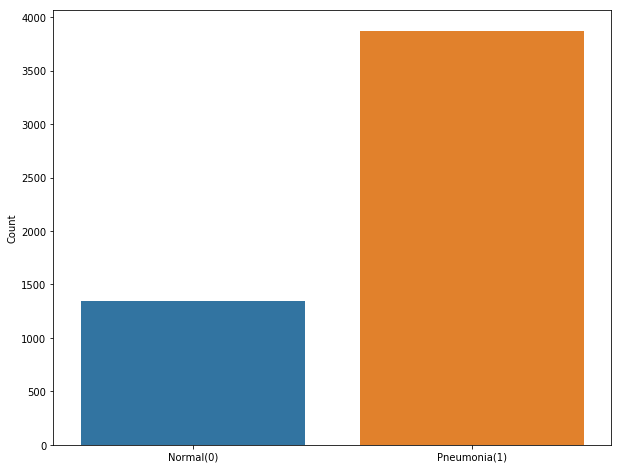

In [0]:
count = train_data['label'].value_counts()
print(count)

# visulaising labels
plt.figure(figsize=(10,8))
sns.barplot(x=count.index, y= count.values)
plt.ylabel('Count')
plt.xticks(range(len(count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

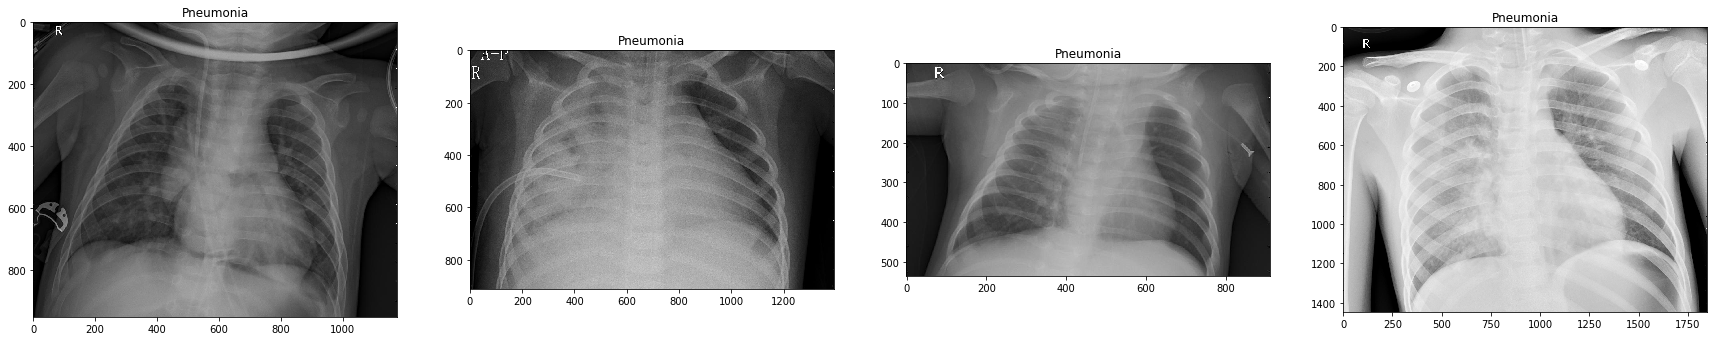

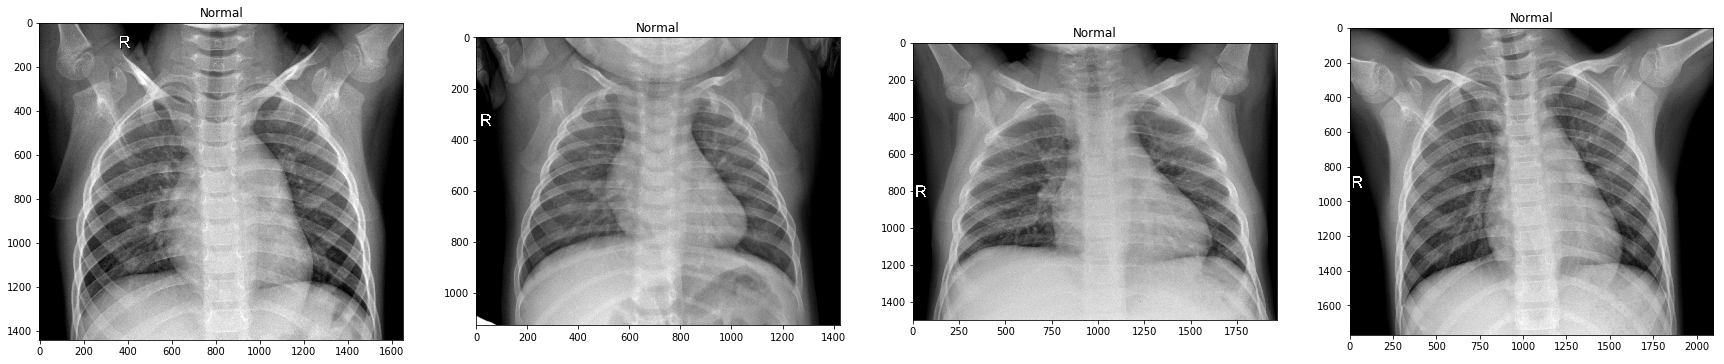

In [0]:
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()


# visualising each classes images  
f, ax = plt.subplots(1,4, figsize=(30,30))

for i in range(4):
    img = imread(pneumonia_samples[i])
    ax[i%4].imshow(img, cmap='gray')
    ax[i%4].set_title("Pneumonia")
plt.show()

f, ax = plt.subplots(1,4, figsize=(30,30))

for i in range(4):
    img = imread(normal_samples[i])
    ax[i%4].imshow(img,cmap='gray')
    ax[i%4].set_title("Normal")
plt.show()

* Data Augmentation

In [0]:
image_size = 224
nb_train_samples = 5216 # number of files in training set
batch_size = 16

EPOCHS = 6
STEPS = nb_train_samples / batch_size

data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                             horizontal_flip = True,
                                             width_shift_range = 0.2,
                                             height_shift_range = 0.2,
                                             shear_range = 0.2,
                                             zoom_range = 0.2
                                            )
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = data_generator_with_aug.flow_from_directory(
       directory = '../input/chest-xray-pneumonia/chest_xray/chest_xray/train/',
       target_size = (image_size, image_size),
       batch_size = batch_size,
       class_mode = 'categorical')

validation_generator = data_generator_no_aug.flow_from_directory(
       directory = '../input/chest-xray-pneumonia/chest_xray/chest_xray/val/',
       target_size = (image_size, image_size),
       class_mode = 'categorical')

test_generator = data_generator_no_aug.flow_from_directory(
       directory = '../input/chest-xray-pneumonia/chest_xray/chest_xray/test/',
       target_size = (image_size, image_size),
       batch_size = batch_size,
       class_mode = 'categorical')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [0]:
train_generator.image_shape


(224, 224, 3)

Traing the Model

In [0]:

vgg_weights_path = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

base_model = tf.keras.applications.VGG16(
    weights=vgg_weights_path,
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

In [0]:

model = base_model.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(units=512, activation='relu')(model)
model = tf.keras.layers.Dropout(0.7)(model)
predictions = tf.keras.layers.Dense(units=2, activation='softmax')(model)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)


In [0]:

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
model.fit_generator(
    train_generator,
    epochs=10,
    verbose=1,
    validation_data=validation_generator,
)

Epoch 1/10
326/326 [==============================] - 139s 427ms/step - loss: 0.5803 - acc: 0.8737 - val_loss: 0.2976 - val_acc: 0.7500
Epoch 2/10
326/326 [==============================] - 117s 360ms/step - loss: 0.2053 - acc: 0.9170 - val_loss: 0.2799 - val_acc: 0.8125
Epoch 3/10
326/326 [==============================] - 119s 364ms/step - loss: 0.1800 - acc: 0.9287 - val_loss: 0.2831 - val_acc: 0.8125
Epoch 4/10
326/326 [==============================] - 116s 357ms/step - loss: 0.1832 - acc: 0.9308 - val_loss: 0.2474 - val_acc: 0.8750
Epoch 5/10
326/326 [==============================] - 116s 357ms/step - loss: 0.1702 - acc: 0.9342 - val_loss: 0.1923 - val_acc: 0.8750
Epoch 6/10
326/326 [==============================] - 116s 357ms/step - loss: 0.1614 - acc: 0.9387 - val_loss: 0.1816 - val_acc: 0.9375
Epoch 7/10
326/326 [==============================] - 117s 358ms/step - loss: 0.1553 - acc: 0.9429 - val_loss: 0.2853 - val_acc: 0.8750
Epoch 8/10
326/326 [============================

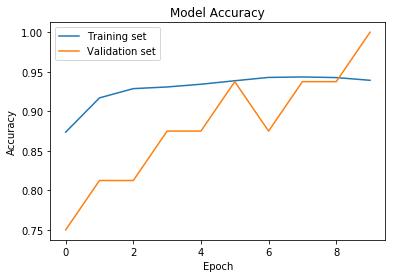

In [0]:
#plotting model accuracy

plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'])
plt.show()

In [0]:
loss, test_acc = model.evaluate_generator(
    test_generator,
    steps=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=True,
    verbose=1
)

print(test_acc)

39/39 [==============================] - 10s 263ms/step - loss: 0.2800 - acc: 0.9087
0.90865386


> Prediction and Confusion matrix

In [0]:
filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator,steps = 
                                   np.ceil(nb_samples/batch_size))

In [0]:
np.shape(predict)

(624, 2)

In [0]:
predict[0]

array([0.9932145 , 0.00678551], dtype=float32)

In [0]:
import collections
pred_y=[]
for i in predict:
    if i[0] > i[1]:
        pred_y.append(0)
    else:
        pred_y.append(1)
collections.Counter(pred_y)

Counter({0: 205, 1: 419})

In [0]:
collections.Counter(test_generator.labels)

Counter({0: 234, 1: 390})

<Figure size 432x288 with 0 Axes>

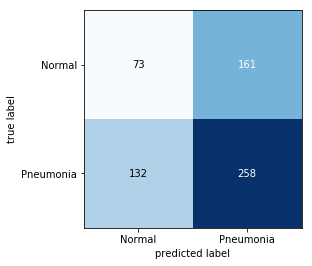

In [0]:

cm = confusion_matrix(test_generator.labels, pred_y)
plt.figure()
plot_confusion_matrix(cm)
plt.xticks(range(2), ['Normal', 'Pneumonia'])
plt.yticks(range(2), ['Normal', 'Pneumonia'])
plt.show()


In [0]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall :",recall)
print("Precision : ",precision)


Recall : 0.6615384615384615
Precision :  0.6157517899761337


In [0]:
WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels.h5'

In [0]:
import keras
base_model = keras.applications.resnet50.ResNet50(weights=None, include_top=False, input_shape= (224,224,3))

In [0]:

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(2, activation= 'softmax')(x)
model1=keras.models.Sequential()
model1 = Model(inputs = base_model.input, outputs = predictions)


In [0]:
model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model1.summary()

In [0]:
model1.fit_generator(
    train_generator,
    epochs=15,
    verbose=1,
    steps_per_epoch = STEPS,
    validation_steps = 1,
    validation_data=validation_generator,
)